Epoch 1/10
1875/1875 [==============================] - 16s 6ms/step - loss: 275.7315 - accuracy: 0.8523 - val_loss: 297.5029 - val_accuracy: 0.8734
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 307.2253 - accuracy: 0.8780 - val_loss: 265.8297 - val_accuracy: 0.9024
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 311.5998 - accuracy: 0.8842 - val_loss: 354.4883 - val_accuracy: 0.8799
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 309.0806 - accuracy: 0.8875 - val_loss: 308.7747 - val_accuracy: 0.9023
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 304.6621 - accuracy: 0.8912 - val_loss: 384.4571 - val_accuracy: 0.8816
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 297.2644 - accuracy: 0.8952 - val_loss: 316.3788 - val_accuracy: 0.8970
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 279.8043 - accuracy: 0.8985 -

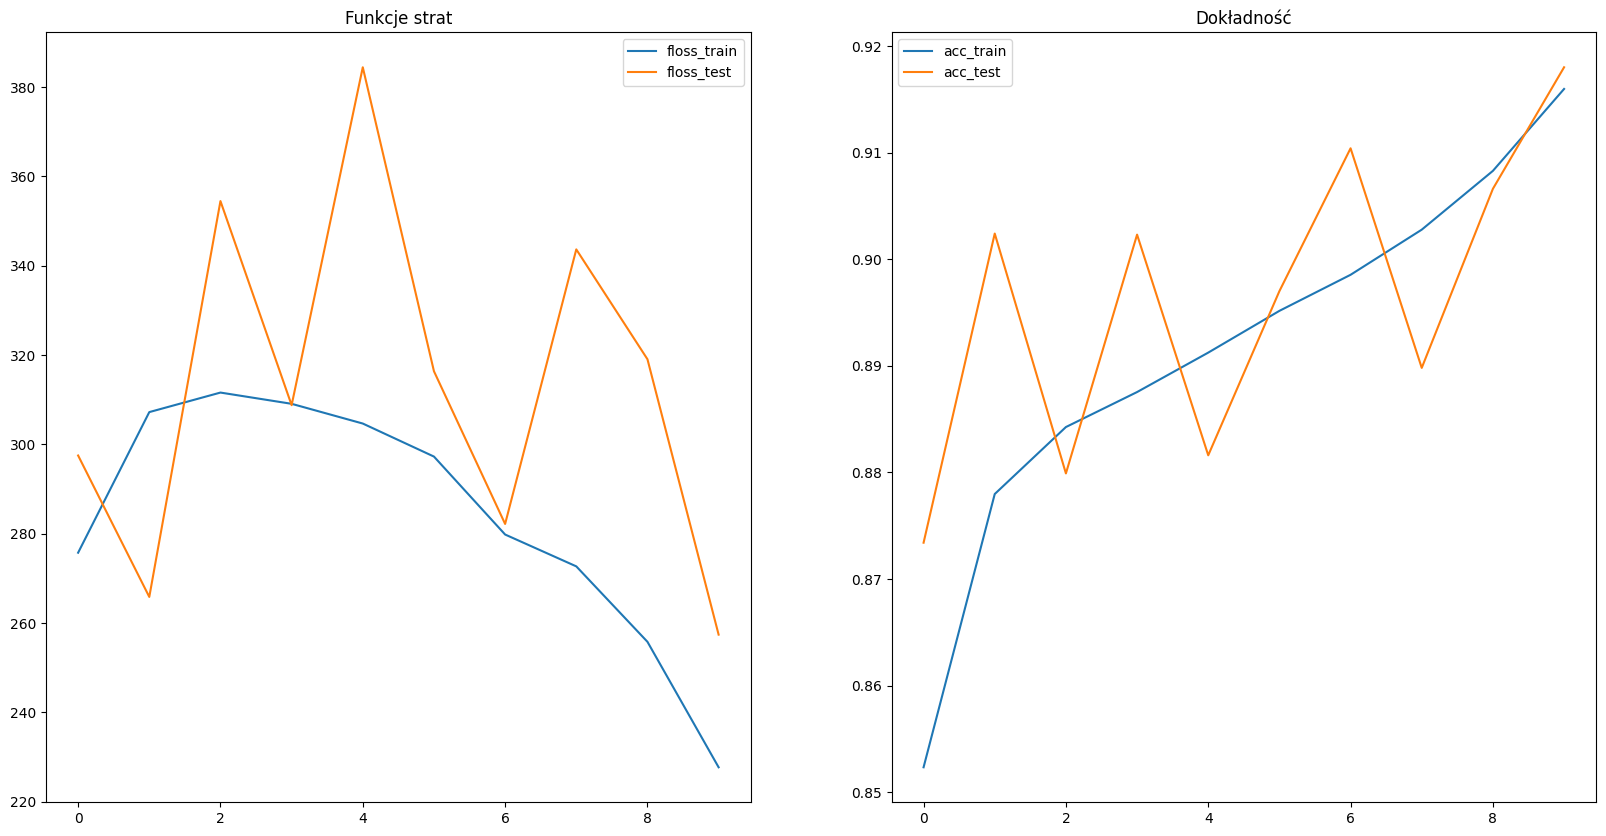

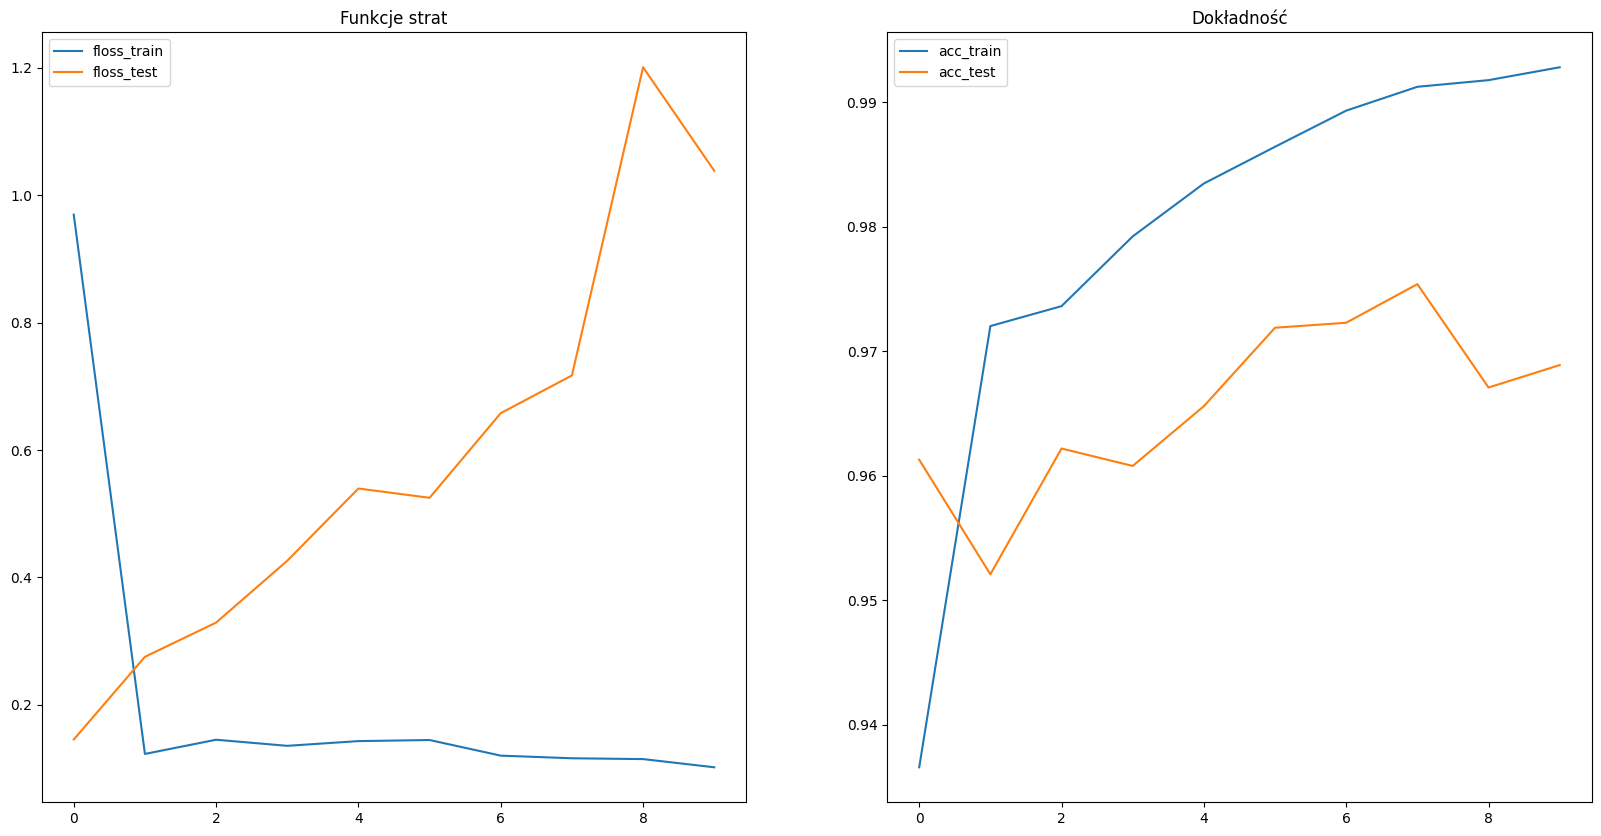

In [2]:
#%%DATA IMPORT
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = mnist.load_data()
X_train, y_train = data[0][0], data[0][1]
X_test, y_test = data[1][0], data[1][1]
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

class_cnt = np.unique(y_train).shape[0]

y_train = pd.get_dummies(pd.Categorical(y_train)).values
y_test = pd.get_dummies(pd.Categorical(y_test)).values
#%%IMPORTS
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Reshape,ReLU, GlobalAveragePooling2D,BatchNormalization,Input,Lambda, concatenate, average, add
from keras.models import Model
from keras.utils.vis_utils import plot_model
#%%DEFAULTS
act_func = 'selu'
#%% LAB8EX1
def buildex1():
  paths = [
      [
          Dense(512,activation=act_func),
          Dense(128,activation=act_func),
          Dense(64,activation=act_func),
          Dense(16,activation=act_func),
          Dense(10,activation=act_func)
      ],
      [
          Dense(512,activation=act_func),
          Dense(64,activation=act_func),
          Dense(10,activation=act_func)
      ],
      [
          Dense(512,activation=act_func),
          Dense(64,activation=act_func),
          Dense(10,activation=act_func)
      ],
      [
          Dense(512,activation=act_func),
          Dense(64,activation=act_func),
          Dense(10,activation=act_func)
      ],
      [
          Dense(512,activation=act_func),
          Dense(64,activation=act_func),
          Dense(10,activation=act_func)
      ]
  ]

  output_tensor = input_tensor = Input(X_train.shape[1:])
  output_tensor = Reshape((784,))(output_tensor)
  output_tensor = BatchNormalization()(output_tensor)

  for_average = []
  for path in paths:
    path_tensor = output_tensor

    for layer in path:
      path_tensor = layer(path_tensor)
    for_average.append(path_tensor)

  output_tensor = average(for_average)
  return Model(inputs = input_tensor, outputs = output_tensor)

ANN = buildex1()
ANN.compile(loss = 'categorical_crossentropy',metrics = 'accuracy',optimizer = 'adam')
plot_model(ANN, show_shapes=True)
#%% LAB8EX2
output_tensor = input_tensor = Input(X_train.shape[1:])
number_of_layers = 2

def buildResNet(input_tensor):
    output_tensor = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation=act_func)(input_tensor)
    output_tensor = BatchNormalization()(output_tensor)
    output_tensor = add([output_tensor,input_tensor])
    output_tensor = ReLU()(output_tensor)
    return output_tensor

for i in range(number_of_layers):
    output_tensor = buildResNet(output_tensor)

output_tensor = Flatten()(output_tensor)
output_tensor = Dense(class_cnt, activation='softmax')(output_tensor)

model = Model(inputs = input_tensor, outputs = output_tensor)
model.compile(loss = 'categorical_crossentropy',metrics = 'accuracy',optimizer = 'adam')
plot_model(model, show_shapes=True)

model.fit(x = X_train, y = y_train, epochs = class_cnt,validation_data=(X_test, y_test))

#CHARTS OF MODEL HISTORY
history = model.history.history
floss_train = history['loss']
floss_test = history['val_loss']
acc_train = history['accuracy']
acc_test = history['val_accuracy']
fig,ax = plt.subplots(1,2, figsize=(20,10))

epochs = np.arange(0, class_cnt)
ax[0].plot(epochs, floss_train, label = 'floss_train')
ax[0].plot(epochs, floss_test, label = 'floss_test')
ax[0].set_title('Funkcje strat')
ax[0].legend()
ax[1].set_title('Dokładność')
ax[1].plot(epochs, acc_train, label = 'acc_train')
ax[1].plot(epochs, acc_test, label = 'acc_test')
ax[1].legend()

print("Najlepsza dokładność na zbiorze testowym: {}".format(max(history['val_accuracy'])))
print("Najlepsza (najmniejsza) strata dla na zbiorze testowym: {}".format(min(history['val_loss'])))
#%% LAB8EX3
input_tensor = Input(X_train.shape[1:])

def buildDenseNet(input_tensor):
    output_tensor = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation=act_func)(input_tensor)
    output_tensor = BatchNormalization()(output_tensor)
    output_tensor = concatenate([output_tensor,input_tensor])
    output_tensor = Conv2D(filters=1,kernel_size=(1,1),padding='same',activation=act_func)(output_tensor)
    return output_tensor

ANN = Model(inputs = input_tensor, outputs = buildDenseNet(input_tensor))
ANN.compile(loss = 'categorical_crossentropy',metrics = 'accuracy',optimizer = 'adam')
plot_model(ANN, show_shapes=True)
#%%LAB8EX4
import tensorflow as tf

def Mish(tensor):
  tensor = tensor * tf.math.tanh(tf.math.softplus(tensor))
  return tensor

output_tensor = input_tensor = Input(X_train.shape[1:])

#for i in range(2):
output_tensor = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation=act_func)(output_tensor)
output_tensor = Lambda(Mish)(output_tensor)

output_tensor = Flatten()(output_tensor)
output_tensor = Dense(class_cnt,activation='softmax')(output_tensor)

model = Model(inputs = input_tensor,outputs = output_tensor)
model.compile(loss = 'categorical_crossentropy',metrics = 'accuracy', optimizer = 'adam')
plot_model(model, show_shapes=True)

model.fit(x = X_train, y = y_train, epochs = class_cnt,validation_data=(X_test, y_test))

#CHARTS OF MODEL HISTORY
history = model.history.history
floss_train = history['loss']
floss_test = history['val_loss']
acc_train = history['accuracy']
acc_test = history['val_accuracy']
fig,ax = plt.subplots(1,2, figsize=(20,10))

epochs = np.arange(0, class_cnt)
ax[0].plot(epochs, floss_train, label = 'floss_train')
ax[0].plot(epochs, floss_test, label = 'floss_test')
ax[0].set_title('Funkcje strat')
ax[0].legend()
ax[1].set_title('Dokładność')
ax[1].plot(epochs, acc_train, label = 'acc_train')
ax[1].plot(epochs, acc_test, label = 'acc_test')
ax[1].legend()

print("Najlepsza dokładność na zbiorze testowym: {}".format(max(history['val_accuracy'])))
print("Najlepsza (najmniejsza) strata dla na zbiorze testowym: {}".format(min(history['val_loss'])))